In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot
from sklearn.model_selection import train_test_split


In [ ]:
data = pd.read_csv('fer2013/fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
num_emotions=data.emotion.unique()

In [ ]:
# creating data dictionary to map labels
label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'} 

In [ ]:
#extracting images from the csv file
np.array(data.pixels.loc[0].split(' ')).reshape(48,48)

array([['70', '80', '82', ..., '52', '43', '41'],
       ['65', '61', '58', ..., '56', '52', '44'],
       ['50', '43', '54', ..., '49', '56', '47'],
       ...,
       ['91', '65', '42', ..., '72', '56', '43'],
       ['77', '82', '79', ..., '105', '70', '46'],
       ['77', '72', '84', ..., '106', '109', '82']], dtype='<U3')

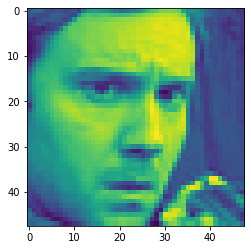

In [ ]:
#visualization of a single image in dataset
pyplot.imshow(np.array(data.pixels.loc[0].split(' ')).reshape(48,48).astype('float'))

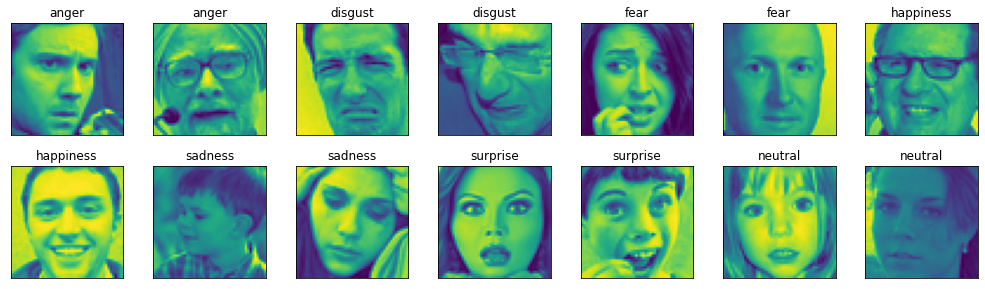

In [ ]:
#visulizing multiple sample data using matplotlib

fig = pyplot.figure(1, (14, 14))
k = 0
for label in sorted(num_emotions):
    for j in range(2):
        px = data[data.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        pyplot.tight_layout()

In [ ]:
#parsing all dataframe into an numpy array of size (48,48)
img_array = data.pixels.apply(lambda x : np.array(x.split(' ')).reshape(48, 48,1).astype('float32'))

In [ ]:
print(img_array.shape)
img_array = np.stack(img_array,axis=0) #joining images to form trainabe image data

(35887,)


In [ ]:
img_array.shape

(35887, 48, 48, 1)

In [ ]:
labels = data.emotion.values
labels=labels.reshape(-1,1)

In [ ]:
from sklearn.utils import shuffle
img_array,labels=shuffle(img_array,labels)

In [ ]:
#one hot encoding for labels for using categorical crossentropy
klearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(labels)
enc_labels=enc.transform(labels)
enc_labels=enc_labels.toarray()
enc_labels[1]

array([0., 0., 0., 0., 0., 1., 0.])

In [ ]:
#splitting train and test data
x_train,x_test,y_train,y_test = train_test_split(img_array,enc_labels,test_size=0.3)

In [ ]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((25120, 48, 48, 1), (10767, 48, 48, 1), (25120, 7), (10767, 7))

In [ ]:
#normalizing image data
X_train = x_train/255.
X_test = x_test/255.

In [ ]:
initializer=tf.keras.initializers.GlorotNormal(seed=None)

In [ ]:
basemodel = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16,(3,3),padding='same',activation='relu', kernel_initializer=initializer, input_shape = (48,48,1)),
                                        tf.keras.layers.MaxPool2D((2,2),padding='same'),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dropout(0.5),
                                        #
                                        tf.keras.layers.Conv2D(32,(3,3),padding='same',activation='relu',kernel_initializer=initializer),
                                        tf.keras.layers.MaxPool2D((2,2),padding='same'),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dropout(0.5),
                                        #
                                        tf.keras.layers.Conv2D(64,(3,3),padding='same',kernel_initializer=initializer,activation='relu'),
                                        tf.keras.layers.MaxPool2D((2,2),padding='same'),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dropout(0.5),
                                        #
                                        tf.keras.layers.Conv2D(128,(3,3),padding='same',kernel_initializer=initializer,activation='relu'),
                                        tf.keras.layers.MaxPool2D((2,2),padding='same'),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dropout(0.5),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(128,kernel_initializer=initializer,activation='relu'),
                                        tf.keras.layers.Dense(7,activation = 'softmax')                          
                                        ])

In [ ]:
basemodel.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 16)       64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 24, 24, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0

In [ ]:
basemodel.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

In [ ]:
import os
try:
  os.mkdir('checkpoint')
except:
  pass

In [ ]:
file_name = 'best_model.h5'
checkpoint_path = os.path.join('checkpoint',file_name)

call_back = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 monitor='val_accuracy', 
                                                 verbose=1,
                                                 save_freq='epoch',
                                                 save_best_only=True, 
                                                 save_weights_only=False, 
                                                 mode='max')


In [ ]:
%%time
history = basemodel.fit(X_train,y_train,epochs=300,validation_split=0.1,batch_size = 64, shuffle=True, callbacks=call_back)

Epoch 1/300
352/354 [============================>.] - ETA: 0s - loss: 1.7358 - accuracy: 0.3107
Epoch 00001: val_accuracy improved from 0.28901 to 0.29339, saving model to checkpoint/best_model.h5
354/354 [==============================] - 7s 19ms/step - loss: 1.7354 - accuracy: 0.3109 - val_loss: 1.7622 - val_accuracy: 0.2934
Epoch 2/300
351/354 [============================>.] - ETA: 0s - loss: 1.7165 - accuracy: 0.3139
Epoch 00002: val_accuracy improved from 0.29339 to 0.30613, saving model to checkpoint/best_model.h5
354/354 [==============================] - 6s 16ms/step - loss: 1.7166 - accuracy: 0.3137 - val_loss: 1.7656 - val_accuracy: 0.3061
Epoch 3/300
351/354 [============================>.] - ETA: 0s - loss: 1.7065 - accuracy: 0.3240
Epoch 00003: val_accuracy improved from 0.30613 to 0.30812, saving model to checkpoint/best_model.h5
354/354 [==============================] - 6s 16ms/step - loss: 1.7070 - accuracy: 0.3240 - val_loss: 1.7606 - val_accuracy: 0.3081
Epoch 4/30

In [ ]:
final_model = tf.keras.models.load_model(checkpoint_path)
prediction=final_model.predict(X_test)
a = prediction
b = np.zeros_like(a)
b[np.arange(len(a)), a.argmax(1)] = 1
prediction= enc.inverse_transform(b)

In [ ]:
Y_test_inv=enc.inverse_transform(y_test)

In [ ]:
pred=prediction.flatten()
y_true=Y_test_inv.flatten()

actual label is sadness
predicted label is sadness


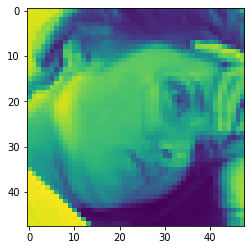

KeyboardInterrupt: ignored

In [ ]:
final_model = tf.keras.models.load_model(checkpoint_path)
from IPython.display import clear_output
import time
for k in range(40):
  print(f'actual label is {label_to_text[y_true[k]]}')
  print(f'predicted label is {label_to_text[pred[k]]}')
  pyplot.imshow(X_test[k].reshape((48,48)))
  pyplot.show()
  time.sleep(5)
  clear_output(wait = True)


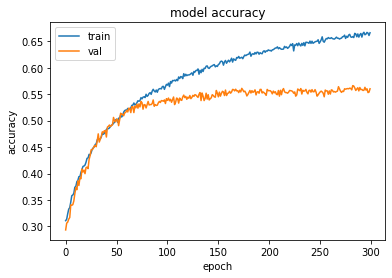

In [ ]:
import keras
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

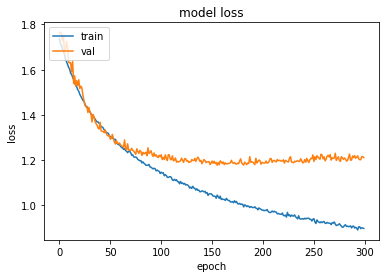

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()